In [1]:
# Loading Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score,f1_score, make_scorer, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Reading data set

bank_df = pd.read_csv('https://raw.githubusercontent.com/neerajviswajith/CE888/main/Modelling/bank-additional-full.csv', sep = ';')

In [3]:
# Checking for Nan values

print(bank_df.isnull().values.any(),bank_df.isnull().sum().sum())

False 0


In [4]:
# Dropping Default Column

bank_df.drop(columns='duration', inplace=True)

In [5]:
bank_df.head(15)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
#Encoding categorical variables.
bank_df = pd.get_dummies(bank_df, columns=['job','marital','default','education',
                                           'housing','loan','contact','month',
                                           'day_of_week','poutcome'], drop_first=True)


In [7]:
# Label encoding depedent variable
le = preprocessing.LabelEncoder()
bank_df['y'] = le.fit_transform(bank_df['y'])

In [8]:
bank_df.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [9]:
# Splitting Independent and Dependent Variable

X = bank_df.drop(columns='y').copy().values
y = bank_df['y'].copy().values.reshape(len(bank_df['y']),1)

In [10]:
# Dataset Imbalance

cnt = np.unique(y,return_counts=True)
imbalance = cnt[1][1]/cnt[1][0]
print(f'Dataset imbalance: {imbalance}')

Dataset imbalance: 0.126956331399803


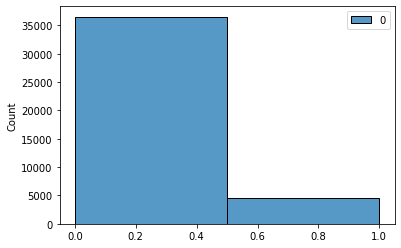

In [11]:
# Plotting Labels

sns_plot = sns.histplot(y,bins=2)

In [12]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify = y)

In [13]:
# K-Fold Cross Validation

classifier = RandomForestClassifier(n_estimators=100,max_depth=3)
CV_acc = cross_val_score(classifier,X_train,y_train.reshape(len(y_train),),cv=10, scoring='accuracy')
CV_f1 = cross_val_score(classifier,X_train,y_train.reshape(len(y_train),),cv=10, scoring='f1')
print(f'Accuracy = {round(CV_acc.mean()*100,2)}%')
print(f'F1-Score = {CV_f1.mean()}')
print(f'Acc. Std. Deviation = +/- {round(CV_acc.std()*100,2)}%')
print(f'F1 Std. Deviation = +/- {CV_f1.std()}')

Accuracy = 89.85%
F1-Score = 0.2583892306049283
Acc. Std. Deviation = +/- 0.4%
F1 Std. Deviation = +/- 0.04245126446358269


In [14]:
# Comparing with dummy Classifier

dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train.reshape(len(y_train),))
print(f'Dummy Classifier Accuracy: {accuracy_score(y_train.reshape(len(y_train),), dummy_clf.predict(X_train))*100}%')

Dummy Classifier Accuracy: 79.85128983308043%


In [15]:
len(X_train)

32950

In [16]:
# GridSearch Cross-Validation 

parameters = {'n_estimators':[100,500,1000],
              'criterion':('gini','entropy'),
              'max_features':('auto','log2')}

GSCV = GridSearchCV(RandomForestClassifier(random_state=0),
                    parameters,
                    scoring='f1',
                    n_jobs=-1,
                    cv=10)

GSCV.fit(X_train,y_train.reshape(len(y_train),))
print(f'Best Paremeters: {GSCV.best_params_}')
#{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000}

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Paremeters: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000}


In [24]:
#Best Features
classifier.fit(X_train,y_train.reshape(len(y_train),))
classifier.feature_importances_
ft_dict = {'Feature':bank_df.drop(columns='y').copy().columns,'Score':classifier.feature_importances_}
feature_df = pd.DataFrame(ft_dict)
feature_df = feature_df.sort_values('Score',ascending=False)

# 3 Most important features.
feature_df.head(3)

,Feature,Score
7,euribor3m,0.184595
8,nr.employed,0.163296
4,emp.var.rate,0.140791


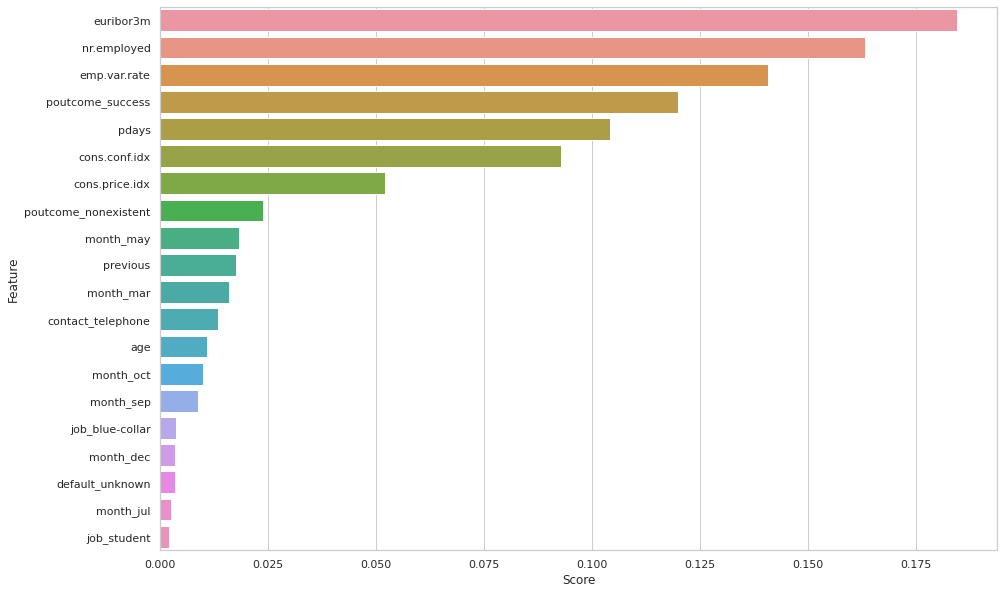

In [30]:
# Plotting Features

sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Score", y="Feature", data=feature_df.head(20))

In [35]:
# Generalisation Error for Basic Classifier

y_pred = classifier.predict(X_test)

print(f'Accuracy = {accuracy_score(y_pred,y_test)*100}%\n')
print(f'F1-Score = {f1_score(y_pred,y_test)}\n')
print(f'Confusion Matrix:\n {confusion_matrix(y_pred,y_test)}\n')
print(f'Classification Report:\n {classification_report(y_pred,y_test)}\n')

Accuracy = 89.98543335761107%

F1-Score = 0.2819843342036553

Confusion Matrix:
 [[7251  766]
 [  59  162]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95      8017
           1       0.17      0.73      0.28       221

    accuracy                           0.90      8238
   macro avg       0.58      0.82      0.61      8238
weighted avg       0.97      0.90      0.93      8238




In [36]:
# Generalisation Error for Optimised Classifier

ny_pred = GSCV.best_estimator_.predict(X_test)

print(f'Accuracy = {accuracy_score(ny_pred,y_test)*100}%\n')
print(f'F1-Score = {f1_score(ny_pred,y_test)}\n')
print(f'Confusion Matrix:\n {confusion_matrix(ny_pred,y_test)}\n')
print(f'Classification Report:\n {classification_report(ny_pred,y_test)}\n')

Accuracy = 89.25710123816461%

F1-Score = 0.39091534755677904

Confusion Matrix:
 [[7069  644]
 [ 241  284]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      7713
           1       0.31      0.54      0.39       525

    accuracy                           0.89      8238
   macro avg       0.64      0.73      0.67      8238
weighted avg       0.92      0.89      0.91      8238


